## ATTEMPT AT MAKING AN EXPECTED GOALS MODEL

#### DATA EXPLORATION

We start off by importing pandas library to handle the data

In [1]:
import pandas as pd

Reading in the data into a DataFrame

In [2]:
df = pd.read_excel('xgl.xlsx')

The data has quire a few columns related to shots

In [3]:
df.head()

X      Y  a_goals         a_team                date h_a  h_goals  \
0  0.707  0.379        0     Hoffenheim 2015-08-29 17:30:00   h        0   
1  0.728  0.373        1      Darmstadt 2015-09-12 17:30:00   a        0   
2  0.016  0.464        0      Darmstadt 2015-11-01 18:30:00   a        2   
3  0.875  0.521        2      Darmstadt 2015-12-20 20:30:00   a        3   
0  0.927  0.557        2  Werder Bremen 2014-12-07 16:30:00   a        5   

                h_team     id lastAction  match_id  minute          player  \
0            Darmstadt  76737     Aerial      1044      93   György Garics   
1     Bayer Leverkusen  76808       Pass      1053       1   György Garics   
2        VfB Stuttgart  78492       Foul      1118      67   György Garics   
3  Borussia M.Gladbach  79876     Aerial      1173      58   György Garics   
0  Eintracht Frankfurt  27374       Pass      5320      78  Luca Caldirola   

     player_assisted  player_id       result  season   shotType   situation  
0                NaN          2  MissedShots    2015  RightFoot  FromCorner  
1  Konstantin Rausch          2    SavedShot    2015  RightFoot    SetPiece  
2                NaN          2      OwnGoal    2015       Head    SetPiece  
3                NaN          2  MissedShots    2015       Head  FromCorner  
0        Fin Bartels          3         Goal    2014   LeftFoot    OpenPlay

In [4]:
df.describe()

X              Y        a_goals        h_goals  \
count  226499.000000  226499.000000  226499.000000  226499.000000   
mean        0.840279       0.504204       1.202606       1.564700   
std         0.090928       0.132119       1.172551       1.340206   
min         0.003000       0.001000       0.000000       0.000000   
25%         0.775000       0.410000       0.000000       1.000000   
50%         0.859000       0.502000       1.000000       1.000000   
75%         0.907000       0.599000       2.000000       2.000000   
max         0.999000       0.997000       9.000000      10.000000   

                  id       match_id         minute      player_id  \
count  226499.000000  226499.000000  226499.000000  226499.000000   
mean   115749.639764    4913.079400      48.476616    2225.026852   
std     68962.791959    2932.816042      26.579704    1675.144362   
min         1.000000      81.000000       0.000000       2.000000   
25%     56663.500000    2353.000000      26.000000     807.000000   
50%    113368.000000    4795.000000      49.000000    1933.000000   
75%    170021.500000    7515.000000      71.000000    3258.000000   
max    243199.000000   10792.000000     103.000000    7255.000000   

              season  
count  226499.000000  
mean     2015.729778  
std         1.287854  
min      2014.000000  
25%      2015.000000  
50%      2016.000000  
75%      2017.000000  
max      2018.000000

In [5]:
df.describe(include=['O'])

a_team     h_a       h_team lastAction             player  \
count        226499  226499       226499     226499             226499   
unique          160       2          160         39               4846   
top     Real Madrid       h  Real Madrid       Pass  Cristiano Ronaldo   
freq           2391  125415         2437      80110                889   

       player_assisted       result   shotType situation  
count           165662       226499     226499    226499  
unique            4839            6          4         5  
top      Dimitri Payet  MissedShots  RightFoot  OpenPlay  
freq               535        89945     118641    166304

The dataset has around 226,500 shots which aren't really a lot but enough to have a basic model running.

In [6]:
df.columns

Index(['X', 'Y', 'a_goals', 'a_team', 'date', 'h_a', 'h_goals', 'h_team', 'id',
       'lastAction', 'match_id', 'minute', 'player', 'player_assisted',
       'player_id', 'result', 'season', 'shotType', 'situation'],
      dtype='object')

#### PRE-PROCESSING

The X & Y co-ordinates present in the data are scaled from 0 to 1 so I had to find a suitable multipliying factor. The field was considered to be of dimensions of 104*76 yards.
The co-ordinates were scaled acccordingly.

In [7]:
df['X'] = df['X']*104
df['Y'] = df['Y']*76

Let's try and plot the shot locations

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

fig=plt.figure()
#fig,ax = plt.subplots(figsize=(10.4,7.6))
ax=fig.add_subplot(1,1,1)
ax.axis('off')

plt.plot([0,104],[0,0],color="black")
plt.plot([0,0],[76,0],color="black")
plt.plot([0,104],[76,76],color="black")
plt.plot([104,104],[76,0],color="black")
plt.plot([52,52],[0,76],color="black")

plt.plot([104,86.32],[60,60],color="black")
plt.plot([86.32,104],[16,16],color="black")
plt.plot([86.32,86.32],[60,16],color="black")
plt.plot([104,97.97],[48,48],color="black")
plt.plot([104,97.97],[27.968,27.968],color="black")
plt.plot([97.97,97.97],[48,27.968],color="black")

plt.plot([104,104],[34,42],color="red")

penaltySpot = plt.Circle((92.04,38),0.25,color="black")
centreSpot = plt.Circle((52,38),0.5,color="black")
centreCircle = plt.Circle((52,38),10,color="black",fill=False)

D = Arc((92.04,38),height=20,width=20,angle=0,theta1=125,theta2=235,color="black")

ax.add_patch(centreSpot)
ax.add_patch(centreCircle)
ax.add_patch(penaltySpot)
ax.add_patch(D)


plt.scatter(df['X'],df['Y'])
plt.show()

<Figure size 640x480 with 1 Axes>

All the shots are when the team is attacking from right to left. The shots on the left end of the pitch are perhaps own goals that will have to be removed.

We know that distance is a major factor for shots to be converted into goals and thus I added a distance feature. The distance will be measured from the shot location to the centre of the goal.

In [9]:
df['distance'] = (((df['X']-104)**2 + (df['Y']-38)**2)**(1/2))

Another important factor to be taken into account is the angle of view the striker has. A smaller angle will obviously minimize the chance of a shot being converted into a goal.

We use trigonometry to find the angle extended by both the goal posts onto the shot location.



cos c = (A^2+B^2-C^2)/2*A*B

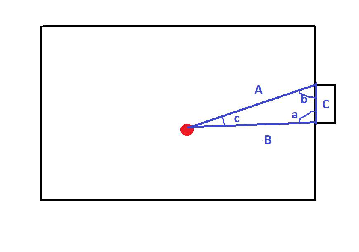

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("angle.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

Pardon my paint skills, but the diagram above explains the angle c we are trying to find. The Red Dot is the shot location and the rectangle on the right is the goalmouth.

Below, I find the distance between the goal posts and the shot location and use it to find the angle extended by the goal onto the shot location.

In [11]:
import math
temp = pd.DataFrame()
temp['a'] = ((df['X']-104)**2 + (df['Y']-42)**2)
temp['b'] = ((df['X']-104)**2 + (df['Y']-34)**2)
df['angle'] = (temp['a']+temp['b']-144)/(2*temp['a']*temp['b'])
df['angle'] = df['angle'].apply(math.acos)

Distance and Angle have been added as columns to the DataFrame.

In [12]:
df.columns

Index(['X', 'Y', 'a_goals', 'a_team', 'date', 'h_a', 'h_goals', 'h_team', 'id',
       'lastAction', 'match_id', 'minute', 'player', 'player_assisted',
       'player_id', 'result', 'season', 'shotType', 'situation', 'distance',
       'angle'],
      dtype='object')

Since the columns in the categs list are actually categories, we convert them into categories.

In [13]:
categs = ['lastAction','result','shotType', 'situation']
for categ in categs:
    df[categ] = df[categ].astype('category')

Let us have a look at the categories for each specific feature.

In [14]:
for categ in categs:
    print(categ)
    print(df[categ].cat.categories)

lastAction
Index(['Aerial', 'BallRecovery', 'BallTouch', 'BlockedPass', 'Card',
       'Challenge', 'ChanceMissed', 'Chipped', 'Clearance', 'CornerAwarded',
       'Cross', 'CrossNotClaimed', 'Dispossessed', 'End', 'Error',
       'FormationChange', 'Foul', 'Goal', 'GoodSkill', 'HeadPass',
       'Interception', 'KeeperPickup', 'KeeperSweeper', 'LayOff', 'None',
       'OffsidePass', 'OffsideProvoked', 'Pass', 'PenaltyFaced', 'Punch',
       'Rebound', 'Save', 'ShieldBallOpp', 'Standard', 'Start',
       'SubstitutionOn', 'Tackle', 'TakeOn', 'Throughball'],
      dtype='object')
result
Index(['BlockedShot', 'Goal', 'MissedShots', 'OwnGoal', 'SavedShot',
       'ShotOnPost'],
      dtype='object')
shotType
Index(['Head', 'LeftFoot', 'OtherBodyPart', 'RightFoot'], dtype='object')
situation
Index(['DirectFreekick', 'FromCorner', 'OpenPlay', 'Penalty', 'SetPiece'], dtype='object')


Before we can train the model, we need to remove any OwnGoals that might spoil the model and thus, we do so.

In [15]:
df = df[df['result'] != 'OwnGoal']

Introducing a binary column by the name of Goal.

In [16]:
df['goal']  = (df['result'] == 'Goal')

One Hot Encoding for the situation column is done in the DataFrame so that Logistic Regression might not misinterpret the situations as something of different weightages.

LabelBinarizer from sklearn is used to carry out the one hot encoding.

In [17]:
from sklearn.preprocessing import LabelBinarizer
le = LabelBinarizer()
le.fit(df['situation'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [18]:
temp = le.transform(df['situation'])

In [19]:
le.classes_

array(['DirectFreekick', 'FromCorner', 'OpenPlay', 'Penalty', 'SetPiece'],
      dtype='<U14')

In [20]:
for i in range(0,len(le.classes_)):
    df['is'+le.classes_[i]] = temp[:,i]

One Hot Encoding of situation column introduces the binary columns isDirectFreekick, isFromCorner, isOpenPlay, isPenalty, isSetPiece.

One Hot Encoding of the shotType column is also done. Columns fromHead, fromLeftFoot, fromOtherBodyPart, fromRightFoot are introduced into tahe dataframe, again with the help of the LabelBinarizer function in the sklearn library.

In [21]:
le.fit(df['shotType'])
temp = le.transform(df['shotType'])

In [22]:
le.classes_

array(['Head', 'LeftFoot', 'OtherBodyPart', 'RightFoot'], dtype='<U13')

In [23]:
for i in range(0,len(le.classes_)):
    df['from'+le.classes_[i]] = temp[:,i]

Let's look at how the dataset looks like now:

In [24]:
df

X          Y  a_goals               a_team                date  \
0    73.527997  28.804001        0           Hoffenheim 2015-08-29 17:30:00   
1    75.712003  28.347999        1            Darmstadt 2015-09-12 17:30:00   
3    91.000000  39.595999        2            Darmstadt 2015-12-20 20:30:00   
0    96.407997  42.332001        2        Werder Bremen 2014-12-07 16:30:00   
1    93.496002  45.447999        2            Darmstadt 2015-09-27 19:30:00   
2   101.920000  35.872001        2            Darmstadt 2015-10-17 17:30:00   
3   102.336002  36.175999        2            Darmstadt 2015-10-17 17:30:00   
4    92.040000  32.907999        0            Darmstadt 2015-11-01 18:30:00   
5    97.967997  48.260000        0            Darmstadt 2015-11-01 18:30:00   
6    99.527997  47.575999        1         Hamburger SV 2015-11-07 21:30:00   
7    94.640000  46.284001        1            Darmstadt 2015-12-06 20:30:00   
8    95.367997  40.280000        1            Darmstadt 2015-12-06 20:30:00   
9    97.032003  42.787999        4        Hertha Berlin 2015-12-12 18:30:00   
10   96.927997  36.404001        2            Darmstadt 2015-12-20 20:30:00   
11   94.847997  46.512001        2     Bayer Leverkusen 2016-02-13 18:30:00   
12   90.376002  48.868002        0            Darmstadt 2016-03-06 18:30:00   
13   90.376002  48.868002        0            Darmstadt 2016-03-06 18:30:00   
14  100.463998  32.527999        2        VfB Stuttgart 2016-04-02 17:30:00   
15   91.416002  39.215999        1            Darmstadt 2016-04-23 17:30:00   
16   77.480000  43.700000        0        Werder Bremen 2016-08-26 22:30:00   
17  103.063998  46.967999        0        Werder Bremen 2016-08-26 22:30:00   
1    98.383998  35.415999        1            Darmstadt 2015-08-22 17:30:00   
2    97.032003  34.352001        1            Darmstadt 2015-08-22 17:30:00   
3    99.007997  32.907999        1            Darmstadt 2015-09-12 17:30:00   
4    91.312003  37.467999        2            Darmstadt 2015-09-27 19:30:00   
5    95.056002  44.384001        0            Darmstadt 2015-11-01 18:30:00   
6    94.223998  43.547999        0            Darmstadt 2015-11-01 18:30:00   
7    92.143998  41.495999        1         Hamburger SV 2015-11-07 21:30:00   
8    99.320000  36.404001        1            Darmstadt 2015-11-22 20:40:00   
9    94.536002  37.315999        1            Darmstadt 2015-12-06 20:30:00   
..         ...        ...      ...                  ...                 ...   
9    83.096002  27.207999        2           Villarreal 2018-11-11 17:30:00   
10   76.543998  38.835999        1           Real Betis 2018-11-25 19:45:00   
11   93.287997  35.112001        1           Real Betis 2018-11-25 19:45:00   
12   92.767997  24.927999        1           Real Betis 2018-11-25 19:45:00   
13   88.712003  24.624001        1           Real Betis 2018-11-25 19:45:00   
14   95.887997  24.016000        0           Villarreal 2018-12-02 17:30:00   
15   81.120000  29.944001        0           Villarreal 2018-12-02 17:30:00   
0    79.143998  40.127999        2               Fulham 2018-10-20 14:00:00   
0    96.303998  35.112001        2              Udinese 2018-10-28 13:00:00   
1    95.887997  37.467999        0                Genoa 2018-11-03 14:00:00   
2    93.912003  42.484001        2               Napoli 2018-11-10 19:30:00   
3    84.343998  35.415999        1            Sampdoria 2018-11-25 19:30:00   
4    96.927997  36.632001        1            Sampdoria 2018-11-25 19:30:00   
5    92.456002  40.964001        1                Genoa 2018-12-02 14:00:00   
6    83.407997  36.555999        1                Genoa 2018-12-02 14:00:00   
0    85.383998  42.560000        0             Toulouse 2018-11-24 16:00:00   
0    92.352003  43.320000        0               Monaco 2018-11-03 19:00:00   
1    84.967997  35.264001        1             Guingamp 2018-11-24 19:00:00   
0    98.487997  33.440000        0      Real Valladolid 2018-11

In [25]:
df.columns

Index(['X', 'Y', 'a_goals', 'a_team', 'date', 'h_a', 'h_goals', 'h_team', 'id',
       'lastAction', 'match_id', 'minute', 'player', 'player_assisted',
       'player_id', 'result', 'season', 'shotType', 'situation', 'distance',
       'angle', 'goal', 'isDirectFreekick', 'isFromCorner', 'isOpenPlay',
       'isPenalty', 'isSetPiece', 'fromHead', 'fromLeftFoot',
       'fromOtherBodyPart', 'fromRightFoot'],
      dtype='object')

Oh Boi, that's a lot of columns. Not to worry though. We will not be using all of them. Only a subset, atleast for this model. This subset is stored in the cols list

In [26]:
cols = ['distance','angle','isDirectFreekick','isFromCorner','isOpenPlay','isPenalty','isSetPiece','fromHead','fromLeftFoot','fromOtherBodyPart','fromRightFoot','goal']

We create a new DataFrame by the name of shot to store the subset data from the selected columns.

In [27]:
shot = df[cols]

The aim of this whole endeavour is to make a model which will output wether a shot is goal or not. Thus, the goal feature is taken as a series by the name of Y and the rest of the independent features are stored in the DataFrame X.

In [28]:
X=shot.drop('goal',axis=1)
Y=shot['goal']

In [29]:
X.columns

Index(['distance', 'angle', 'isDirectFreekick', 'isFromCorner', 'isOpenPlay',
       'isPenalty', 'isSetPiece', 'fromHead', 'fromLeftFoot',
       'fromOtherBodyPart', 'fromRightFoot'],
      dtype='object')

Y series currently consists of values in the form of True and False but we would like it to be a binary value i.e. 1 or 0. Thus, we use LabelEncoder available in the sklearn library.

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y=le.fit_transform(Y)

We will have to construct both a train data set and test data set to check the validity of our model.
Thus, we break up our dataset into two parts in 70:30 ratio. 70% of shots are present in the training set and the rest 30% are used as an hold-out test set.

#### MODEL FITTING & TESTING

Lo and Behold, we are finally at the point to train the model. The first Model that I'm using here is Logistic Regression because it is realtively cheaper computationally.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

reg = LogisticRegression()

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

reg.fit(X_train,Y_train)

D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
reg.score(X_test,Y_test)

0.9048863300856215

We obtain an accuracy of 90.4% which is decent considering the size of data. Moreover, we did not take a lot of features into account.

90% sounds good but it's classifying wheteher a shot is a goal or not and the dataset is skewed towards having a lot more shots as not a goal in comaprisons to ones which actually ended up being a goal.

Thus, judging the performance of a model based on just the accuracy is not a good practice. Let's look at the predictions themselves with the help of a confusion matrix.

In [33]:
preds = reg.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test,preds)
print(confusion_matrix)

[[60210   442]
 [ 6001  1087]]


The Confusion Matrix shows us Exactly how the model performed in terms of raw output. The top left value indicates shots that were rightly predicted as not goals. The righta are shots that were predicted as goals but were not.

The second row contains shots that were classified as not goal but were infact, goals. On the right of it, we have the shots that were correctly classified as goals.

Another tool to look at the performance of the model is an ROC curve. The area under ROC curve for our model is 80% which is quite good.

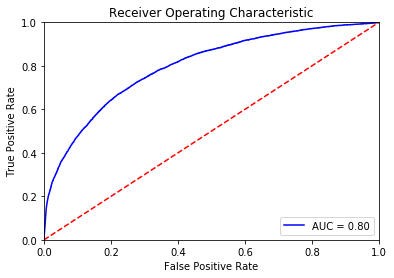

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
probs = reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The same methodology is used to build a Random Forest Classification Model.

In [35]:
from sklearn.ensemble import RandomForestClassifier
reg2 = RandomForestClassifier()
reg2.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
reg2.score(X_test,Y_test)

0.8782698553291999

In [37]:
preds = reg2.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test,preds)
print(confusion_matrix)

[[57700  2952]
 [ 5294  1794]]


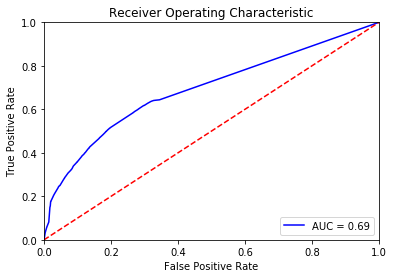

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
probs = reg2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As we see that the both accuracy and area under ROC curve is worse, Logistic Regression seems to be a better choice for our Expected Goals Model.

#### RESUTLS

In [39]:
temp = df[cols]
shots=shot.drop('goal',axis=1)

The below graph shows the value of xG changing as the distance and angle change.

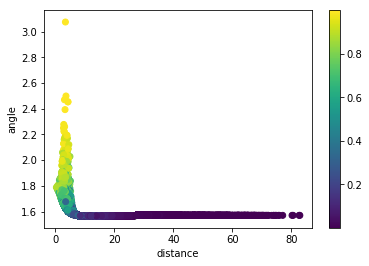

In [40]:
plt.scatter(shots['distance'],shots['angle'],c=reg.predict_proba(shots)[:,1])
plt.xlabel('distance')
plt.ylabel('angle')
plt.colorbar()

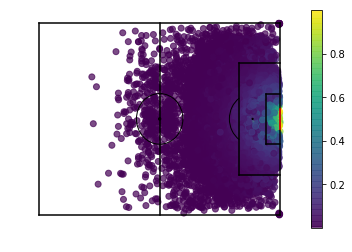

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

fig=plt.figure()
#fig,ax = plt.subplots(figsize=(10.4,7.6))
ax=fig.add_subplot(1,1,1)
ax.axis('off')

plt.plot([0,104],[0,0],color="black")
plt.plot([0,0],[76,0],color="black")
plt.plot([0,104],[76,76],color="black")
plt.plot([104,104],[76,0],color="black")
plt.plot([52,52],[0,76],color="black")

plt.plot([104,86.32],[60,60],color="black")
plt.plot([86.32,104],[16,16],color="black")
plt.plot([86.32,86.32],[60,16],color="black")
plt.plot([104,97.97],[48,48],color="black")
plt.plot([104,97.97],[27.968,27.968],color="black")
plt.plot([97.97,97.97],[48,27.968],color="black")

plt.plot([104,104],[34,42],color="red")

penaltySpot = plt.Circle((92.04,38),0.25,color="black")
centreSpot = plt.Circle((52,38),0.5,color="black")
centreCircle = plt.Circle((52,38),10,color="black",fill=False)

D = Arc((92.04,38),height=20,width=20,angle=0,theta1=125,theta2=235,color="black")

ax.add_patch(centreSpot)
ax.add_patch(centreCircle)
ax.add_patch(penaltySpot)
ax.add_patch(D)


plt.scatter(df['X'],df['Y'],c=reg.predict_proba(shots)[:,1],alpha=0.7)
plt.colorbar()
plt.show()


The above graph shows that our xG model atleast captures the intuitive nature of shot conversion. A shot from a greater angle of view and lesser distance is more likely to go in.

Thus, we add the model output of xG to the original dataframe

In [42]:
df['xG'] = reg.predict_proba(shots)[:,1]

In [43]:
df.columns

Index(['X', 'Y', 'a_goals', 'a_team', 'date', 'h_a', 'h_goals', 'h_team', 'id',
       'lastAction', 'match_id', 'minute', 'player', 'player_assisted',
       'player_id', 'result', 'season', 'shotType', 'situation', 'distance',
       'angle', 'goal', 'isDirectFreekick', 'isFromCorner', 'isOpenPlay',
       'isPenalty', 'isSetPiece', 'fromHead', 'fromLeftFoot',
       'fromOtherBodyPart', 'fromRightFoot', 'xG'],
      dtype='object')

Text(0,0.5,'Expected Goals')

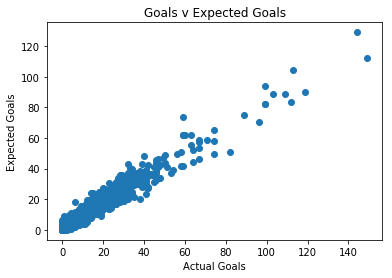

In [44]:
Actual = df.groupby('player')['goal'].sum()
Expected = df.groupby('player')['xG'].sum()

plt.scatter(Actual,Expected)
plt.title('Goals v Expected Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Expected Goals')

We can see that a clear linear relationship exists between the Expected Goals and Actual Goals which is a very good sign for our model.
Let's try fitting a line to this.

Text(0,0.5,'Expected Goals')

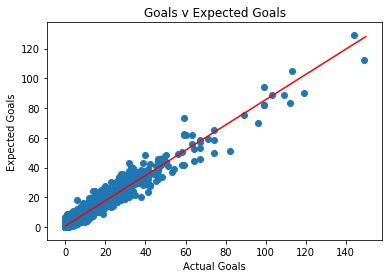

In [45]:
import numpy as np
from sklearn.linear_model import LinearRegression
lmod = LinearRegression()
lmod.fit(np.array(Actual).reshape(-1,1),Expected)

x=np.linspace(0,150,1000)
y=lmod.predict(x.reshape(-1,1))

plt.plot(x,y,color='r')
plt.scatter(Actual,Expected)
plt.title('Goals v Expected Goals')
plt.xlabel('Actual Goals')
plt.ylabel('Expected Goals')

On a side note, 10 Ballon D'or on the top right.

### CONCLUSION

The model was rather simplistic in nature and was made with very few features still managed to capture the intuitiveness of the data and is decent at predicting the number of goals given shot locations and some context data. 

The model could be refined more with more context and more importantly, more data.